Script for computing visuomemory index in block b2
- First, we detect neurons involved in the task computing the t-test between activity during trial vs baseline
- Second, from those neurons we compare the fr response against oposit positions (t-test to check significance)
- Third, compute indices for evaluating if visual or memory neuron  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.spike_sorting import config
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.analysis import circular_stats
from ephysvibe.task import task_constants
import os 
seed=2023

## Def funtions

In [2]:
def get_trials(code, target_codes):
    code_order = np.array(["127", "126", "125", "124", "123", "122", "121", "120"])
    code_pos = np.where(code_order == code)[0][0]
    next = code_pos + 1
    if next == len(code_order):
        next = 0
    next = code_order[next]
    prev = code_pos - 1
    prev = code_order[prev]
    next_idx = np.array(target_codes[next]["trial_idx"]).astype(int)
    prev_idx = np.array(target_codes[prev]["trial_idx"]).astype(int)
    return next_idx, prev_idx

In [3]:
def get_neurons_info(
    sp_samples: np.ndarray,
    fix_t: int,
    neuron_type: np.ndarray,
    target_codes: Dict,
    ipsi: np.ndarray,
    dur_v: int,
    st_m: int,
    end_m: int,
    neuron_idx: np.ndarray = None,
    min_trials: int = 3,
) -> pd.DataFrame:
    if neuron_idx is None:
        neuron_idx = np.arange(0, len(neuron_type))
    codes = target_codes.keys()
    neurons_info: Dict[str, list] = defaultdict(list)
    i_good, i_mua, n_type = 0, 0, 0
    for i_neuron, type_neuron in zip(neuron_idx, neuron_type):
        # check and count type of unit
        if type_neuron == "good":
            i_good += 1
            n_type = i_good
        elif type_neuron == "mua":
            i_mua += 1
            n_type = i_mua
        for code in codes:  # iterate by code'
            trial_idx = np.array(target_codes[code]["trial_idx"]).astype(int)
            if len(trial_idx) != 0:
                trial_idx = trial_idx[(sp_samples[trial_idx, i_neuron].sum(axis=1) > 0)]
            n_tr = len(trial_idx)
            larger = False
            p = None
            if n_tr <= min_trials:  # if less than x tr, use tr from adjacent locations
                next_idx, prev_idx = get_trials(code, target_codes)
                if len(next_idx) != 0:
                    next_idx = next_idx[
                        (sp_samples[next_idx, i_neuron].sum(axis=1) > 0)
                    ]
                if len(prev_idx) != 0:
                    prev_idx = prev_idx[
                        (sp_samples[prev_idx, i_neuron].sum(axis=1) > 0)
                    ]
                n_tr_min = np.min([len(next_idx), len(prev_idx)])
                rng = np.random.default_rng(seed=seed)
                next_idx = rng.choice(next_idx, size=n_tr_min, replace=False)
                prev_idx = rng.choice(prev_idx, size=n_tr_min, replace=False)
                trial_idx = np.concatenate([trial_idx, next_idx, prev_idx]).astype(int)
            n_tr = len(trial_idx)
            if n_tr >= min_trials:  # if enough tr, compute p value
                mean_visual = sp_samples[
                    trial_idx, i_neuron, fix_t : fix_t + dur_v
                ].mean(axis=1)
                mean_prep = sp_samples[
                    trial_idx, i_neuron, fix_t + st_m : fix_t + end_m
                ].mean(axis=1)
                mean_bl = sp_samples[trial_idx, i_neuron, :fix_t].mean(axis=1)
                v_larger = mean_bl.mean() < mean_visual.mean()
                p_larger = mean_bl.mean() < mean_prep.mean()
                larger = v_larger or p_larger
                p_v = stats.ttest_rel(mean_bl, mean_visual)[1]
                p_p = stats.ttest_rel(mean_bl, mean_prep)[1]
                p = np.min([p_v, p_p])
            if code in ipsi:
                laterality = "ipsi"
            else:
                laterality = "contra"
            neurons_info["code"] += [code]
            neurons_info["p"] += [p]
            neurons_info["larger"] += [larger]
            neurons_info["laterality"] += [laterality]
            neurons_info["cluster"] += [n_type]
            neurons_info["group"] += [type_neuron]
            neurons_info["array_position"] += [i_neuron]
    neurons_info = pd.DataFrame(neurons_info)
    return neurons_info


In [4]:
def get_responding_neurons(
    neurons_info: pd.DataFrame,
    epochs: Dict,
    before_trial: int,
    code_samples: np.ndarray,
    code_numbers: np.ndarray,
    sp_samples: np.ndarray,
    align_event: int,
    target_codes: Dict,
) -> pd.DataFrame:
    end_time = np.array(epochs["end_time"]) + before_trial
    start_time = np.array(epochs["start_time"]) + before_trial
    test_involved: Dict[str, list] = defaultdict(list)

    for _, row in neurons_info.iterrows():
        i_neuron = row["array_position"]
        code = row["code"]
        for i_st, i_end, i_epoch in zip(
            start_time, end_time, epochs["name"]
        ):  # iterate by event
            target_t_idx = target_codes[code][
                "trial_idx"
            ]  # select trials with the same stimulus location
            trials_event_time = code_samples[
                target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]
            ]  # moment when the target_on ocurrs in each trial
            shift_sp = SpikeData.indep_roll(
                sp_samples[target_t_idx, i_neuron],
                -(trials_event_time - before_trial).astype(int),
                axis=1,
            )  # align trials with (target_on - before_trial)
            # select trials with at least  5sp/sec
            shift_sp = shift_sp[
                np.nansum(shift_sp[:, before_trial : before_trial + 1100], axis=1) > 0
            ]
            # check number of trials
            if (
                shift_sp.shape[0] > 1
            ):  # if at least 2 trials, compute and save t-test in pd.DataFrame
                # mean fr during event
                mean_sp = (
                    shift_sp[:, i_st:i_end].sum(axis=0)
                    / shift_sp.shape[0]
                    * (i_end - i_st)
                )  # Average fr of all trials
                # mean fr during fixation
                mean_sp_fix = (
                    shift_sp[:, :before_trial].sum(axis=0)
                    / shift_sp.shape[0]
                    * before_trial
                )  # Average fr of all trials
                p = stats.ttest_ind(mean_sp, mean_sp_fix, equal_var=False)[1]
                message = ""
            else:
                p = np.nan
                message = "less than %s spikes" % 0
            test_involved["code"] += [code]
            test_involved["laterality"] += [row["laterality"]]
            test_involved["cluster"] += [row["cluster"]]
            test_involved["group"] += [row["group"]]
            test_involved["array_position"] += [i_neuron]
            test_involved["event"] += [i_epoch]
            test_involved["p"] += [p]
            test_involved["message"] += [message]
    test_involved = pd.DataFrame(test_involved)

    return test_involved

In [5]:
def get_rf(
    th_involved: pd.DataFrame,
    sp_samples: np.ndarray,
    ipsi: np.ndarray,
    contra: np.ndarray,
    target_codes: Dict,
    fix_t: int,
    dur_v: int,
    st_m: int,
    end_m: int,
    min_trials: int = 5,
) -> pd.DataFrame:
    test_rf: Dict[str, list] = defaultdict(list)
    for _, row in th_involved.iterrows():
        p, p_v, p_p = np.nan, np.nan, np.nan
        larger, v_larger, p_larger = False, False, False
        i_neuron = row["array_position"]
        code = row["code"]

        if code in ipsi:
            idx = np.where(ipsi == code)[0]
            opposite_code = contra[idx][0]
        else:
            idx = np.where(contra == code)[0]
            opposite_code = ipsi[idx][0]
        # code
        code_t_idx = np.array(
            target_codes[code]["trial_idx"], dtype=int
        )  # select trials with the same stimulus
        if len(code_t_idx) != 0:
            code_t_idx = code_t_idx[(sp_samples[code_t_idx, i_neuron].sum(axis=1) > 0)]
        if code_t_idx.shape[0] < min_trials:
            next_idx, prev_idx = get_trials(code, target_codes)
            next_idx = next_idx[(sp_samples[next_idx, i_neuron].sum(axis=1) > 0)]
            prev_idx = prev_idx[(sp_samples[prev_idx, i_neuron].sum(axis=1) > 0)]
            n_tr_min = np.min([len(next_idx), len(prev_idx)])

            rng = np.random.default_rng(seed=seed)
            next_idx = rng.choice(next_idx, size=n_tr_min, replace=False)
            prev_idx = rng.choice(prev_idx, size=n_tr_min, replace=False)
            code_t_idx = np.concatenate([code_t_idx, next_idx, prev_idx])
            if len(code_t_idx) != 0:
                code_t_idx = code_t_idx[
                    (sp_samples[code_t_idx, i_neuron].sum(axis=1) > 0)
                ]

        # opposite_code
        oppos_t_idx = np.array(
            target_codes[opposite_code]["trial_idx"], dtype=int
        )  # select trials with the same stimulus
        if len(oppos_t_idx) != 0:
            oppos_t_idx = oppos_t_idx[
                (sp_samples[oppos_t_idx, i_neuron].sum(axis=1) > 0)
            ]
        if oppos_t_idx.shape[0] < min_trials:
            next_idx, prev_idx = get_trials(opposite_code, target_codes)
            next_idx = next_idx[(sp_samples[next_idx, i_neuron].sum(axis=1) > 0)]
            prev_idx = prev_idx[(sp_samples[prev_idx, i_neuron].sum(axis=1) > 0)]
            n_tr_min = np.min([len(next_idx), len(prev_idx)])
            rng = np.random.default_rng(seed=seed)
            next_idx = rng.choice(next_idx, size=n_tr_min, replace=False)
            prev_idx = rng.choice(prev_idx, size=n_tr_min, replace=False)
            oppos_t_idx = np.concatenate([oppos_t_idx, next_idx, prev_idx])
            if len(oppos_t_idx) != 0:
                oppos_t_idx = oppos_t_idx[
                    (sp_samples[oppos_t_idx, i_neuron].sum(axis=1) > 0)
                ]

        if code_t_idx.shape[0] >= min_trials and oppos_t_idx.shape[0] >= min_trials:
            sp_code = sp_samples[code_t_idx, i_neuron, fix_t:]
            sp_oppos = sp_samples[oppos_t_idx, i_neuron, fix_t:]
            # visual
            mean_sp_code = sp_code[:, :dur_v].mean(axis=1)
            mean_sp_opposite = sp_oppos[:, :dur_v].mean(axis=1)
            p_v = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]
            v_larger = mean_sp_code.mean() > mean_sp_opposite.mean()
            # preparatory
            mean_sp_code = sp_code[:, st_m:end_m].mean(axis=1)
            mean_sp_opposite = sp_oppos[:, st_m:end_m].mean(axis=1)
            p_p = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]
            p_larger = mean_sp_code.mean() > mean_sp_opposite.mean()
            p = np.min([p_v, p_p])
            larger = v_larger or p_larger

        test_rf["code"] += [code]
        test_rf["array_position"] += [i_neuron]
        test_rf["p"] += [p]
        test_rf["larger"] += [larger]
        test_rf["p_v"] += [p_v]
        test_rf["v_larger"] += [v_larger]
        test_rf["p_p"] += [p_p]
        test_rf["p_larger"] += [p_larger]
        test_rf["cluster"] += [row["cluster"]]
        test_rf["group"] += [row["group"]]
    test_rf = pd.DataFrame(test_rf)
    return test_rf

In [6]:
def moving_average(data: np.ndarray, win: int, step: int = 1) -> np.ndarray:
    d_shape = data.shape
    d_avg = np.zeros((d_shape[0], int(np.floor(d_shape[1] / step))))
    count = 0
    for i_step in np.arange(0, d_shape[1] - step, step):
        d_avg[:, count] = np.mean(data[:, i_step : i_step + win], axis=1)
        count += 1
    return d_avg

In [7]:
def get_vm_index(
    th_rf,
    target_codes,
    sp_samples,
    fix_t,
    dur_v,
    st_m,
    end_m,
    min_trials,
):
    test_vm: Dict[str, list] = defaultdict(list)
    for _, row in th_rf.iterrows():
        i_neuron = row["array_position"]
        code = row["code"]
        vm_index = np.nan
        sig_type = np.nan
        # select trials

        target_t_idx = np.array(
            target_codes[code]["trial_idx"], dtype=int
        )  # select trials with the same stimulus
        if len(target_t_idx) != 0:
            target_t_idx = target_t_idx[
                (sp_samples[target_t_idx, i_neuron].sum(axis=1) > 0)
            ]
        all_trials_sp = []
        for i_code in target_codes.keys():
            all_trials = np.array(
                target_codes[i_code]["trial_idx"], dtype=int
            )  # select trials with the same stimulus
            if len(all_trials) != 0:
                all_trials = all_trials[
                    (sp_samples[all_trials, i_neuron].sum(axis=1) > 0)
                ]
            all_trials = sp_samples[all_trials, i_neuron, fix_t:]  # .mean(axis=0)

            all_trials_sp.append(
                [all_trials[:, 50:dur_v].mean(), all_trials[:, st_m:end_m].mean()]
            )

        all_trials_sp = np.concatenate(all_trials_sp)
        min_sp = np.nanmin(all_trials_sp)
        max_sp = np.nanmax(all_trials_sp) - min_sp

        if target_t_idx.shape[0] <= min_trials:
            next_idx, prev_idx = get_trials(code, target_codes)
            n_tr_min = np.min([len(next_idx), len(prev_idx)])
            rng = np.random.default_rng(seed=seed)
            next_idx = rng.choice(next_idx, size=n_tr_min, replace=False)
            prev_idx = rng.choice(prev_idx, size=n_tr_min, replace=False)
            target_t_idx = np.concatenate([target_t_idx, next_idx, prev_idx])
            target_t_idx = target_t_idx[
                (sp_samples[target_t_idx, i_neuron].sum(axis=1) > 0)
            ]
        if target_t_idx.shape[0] >= min_trials:
            sp_code = sp_samples[target_t_idx, i_neuron, fix_t:]
            sp_trial_avg = sp_code.mean(axis=0)
            v_mean = (sp_trial_avg[50:dur_v].mean() - min_sp) / max_sp
            m_mean = (sp_trial_avg[st_m:end_m].mean() - min_sp) / max_sp

            vm_index = (m_mean - v_mean) / (v_mean + m_mean)
            if vm_index <= 0:
                sig_type = "visual"
            else:
                sig_type = "anticipation"
        # save results
        test_vm["code"] += [code]
        test_vm["array_position"] += [i_neuron]
        test_vm["vm_index"] += [vm_index]
        test_vm["sig_type"] += [sig_type]
        test_vm["cluster"] += [row["cluster"]]
        test_vm["group"] += [row["group"]]
        test_vm["p_v"] += [row["p_v"]]
        test_vm["v_larger"] += [row["v_larger"]]
        test_vm["p_p"] += [row["p_p"]]
        test_vm["p_larger"] += [row["p_larger"]]
    test_vm = pd.DataFrame(test_vm)
    return test_vm


In [8]:
def get_max_fr(
    target_codes,
    sp_samples,
    code_samples,
    code_numbers,
    i_n,
    kernel,
    win_size,
    fix_t,
    dur_v,
    e_code_align,
    test_vm,
    fs_ds,
):
    fr_max_visual, fr_max_motor, fr_angle, fr_max_codes = [], [], [], []
    v_significant, m_significant = [], []
    for code in target_codes.keys():
        target_t_idx = target_codes[code][
            "trial_idx"
        ]  # select trials with the same stimulus
        trials_s_on = code_samples[
            target_t_idx, np.where(code_numbers[target_t_idx] == e_code_align)[1]
        ]
        shift_sp = SpikeData.indep_roll(
            sp_samples[target_t_idx, i_n], -(trials_s_on).astype(int), axis=1
        )  # align trials on event
        # select trials with at least one spike
        shift_sp = shift_sp[np.nansum(shift_sp[:, : 1100 + fix_t], axis=1) > 0, fix_t:]
        mean_sp = np.nanmean(shift_sp, axis=0)  # mean of all trials
        if shift_sp.shape[0] == 0:
            conv = np.zeros((1100))
        else:
            conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        fr_max_visual.append(np.nanmax(conv[:dur_v]))
        fr_angle.append(target_codes[code]["angle_codes"])
        fr_max_motor.append(np.nanmax(conv[700:1100]))
        fr_max_codes.append(np.nanmax(conv[:1100]))
        if (
            code
            in test_vm[
                (test_vm["array_position"] == i_n) & (test_vm["sig_type"] == "visual")
            ]["code"].values
        ):
            v_significant.append(True)
        else:
            v_significant.append(False)
        if (
            code
            in test_vm[
                (test_vm["array_position"] == i_n)
                & (test_vm["sig_type"] == "anticipation")
            ]["code"].values
        ):
            m_significant.append(True)
        else:
            m_significant.append(False)
    return (
        np.array(fr_max_visual),
        np.array(fr_max_motor),
        np.array(fr_angle),
        np.array(fr_max_codes),
        np.array(v_significant),
        np.array(m_significant),
    )

## Load data

In [9]:
# load data
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-02-09_10-42-54_Riesling_lip_e1_r1_sp.h5"  #2023-02-27_10-50-03 2023-02-09_10-42-54 2023-03-21_10-40-02
s_path = os.path.normpath(filepath).split(os.sep)
data = SpikeData.from_python_hdf5(filepath)

In [10]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 4


In [11]:
# Define target codes 
position_codes= {
    # code: [[MonkeyLogic axis], [plot axis]]
    '127': [[10,0],[1,2],[0]],
    '126': [[7,7],[0,2],[45]],
    '125': [[0,10],[0,1],[90]],
    '124': [[-7,7],[0,0],[135]],
    '123': [[-10,0],[1,0],[180]],
    '122': [[-7,-7],[2,0],[225]],
    '121': [[0,-10],[2,1],[270]],
    '120': [[7,-7],[2,2],[315]],
}
# create dict with the trials having each code
target_codes = {}
for key in position_codes.keys():
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1],'angle_codes':position_codes[key][2][0]}

In [12]:
# Search neurons responding to the task
sp_samples = data.sp_samples
neuron_type = data.clustersgroup
code_samples = data.code_samples
code_numbers = data.code_numbers
sp_samples = data.sp_samples

ipsi = np.array(["124", "123", "122", "121"])
contra = np.array(["120", "127", "126", "125"])

fix_t = 200
dur_v = 200
st_m = 700  # 800
end_m = 1100
p_threshold = 0.05
min_trials = 3

In [13]:
align_event = task_constants.EVENTS_B2["target_on"]
shifts = code_samples[:, 3]
if np.sum(code_numbers[trial_idx, 3] - align_event) != 0:
    print('KeyError')
shifts = shifts[:, np.newaxis]
sp_shift = SpikeData.indep_roll(sp_samples, -(shifts - fix_t).astype(int), axis=2)[
    :, :, : 1100 + fix_t
]
neurons_info = get_neurons_info(
    sp_shift,
    fix_t,
    neuron_type,
    target_codes,
    ipsi,
    dur_v=dur_v,
    st_m=st_m,
    end_m=end_m,
    neuron_idx=None,
    min_trials=min_trials,
)
neurons_info = neurons_info[
    (neurons_info["p"] < 0.05) & (neurons_info["larger"] == True)
]  # responding neurons
neurons_info

,code,p,larger,laterality,cluster,group,array_position
3,124,0.024616,True,ipsi,1,good,0
4,123,0.007183,True,ipsi,1,good,0
8,127,0.041776,True,contra,2,good,1
16,127,0.000002,True,contra,3,good,2
17,126,0.000295,True,contra,3,good,2
18,125,0.000670,True,contra,3,good,2
23,120,0.015068,True,contra,3,good,2


### Neurons RF
Check if signif compared to opposite location

In [14]:
rf_test = get_rf(
    neurons_info,
    sp_shift,
    ipsi,
    contra,
    target_codes,
    fix_t,
    dur_v,
    st_m,
    end_m,
    min_trials=min_trials,
)

th_rf = rf_test[
    np.logical_and(rf_test["p"] < p_threshold, rf_test["larger"] == True)
]  # results below threshold
significant_units = th_rf['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)

th_rf

Units showing significant activity: [0 1 2]


,code,array_position,p,larger,p_v,v_larger,p_p,p_larger,cluster,group
0,124,0,2.008432e-04,True,2.008432e-04,True,0.852890,True,1,good
1,123,0,2.726734e-06,True,2.726734e-06,True,0.839721,False,1,good
2,127,1,9.027202e-04,True,9.027202e-04,True,0.118104,False,2,good
3,127,2,4.771285e-08,True,4.771285e-08,True,0.431792,False,3,good
4,126,2,1.175583e-04,True,1.175583e-04,True,0.062394,False,3,good
5,125,2,2.731973e-03,True,1.918417e-01,True,0.002732,False,3,good
6,120,2,5.968096e-05,True,5.968096e-05,True,0.509717,True,3,good


### Visuomotor index
check whether a neuron is visual, motor or visuomotor comparing the activity during sample presentation vs motor preparation

In [15]:
test_vm = get_vm_index(
    th_rf,
    target_codes,
    sp_shift,
    fix_t,
    dur_v,
    st_m,
    end_m,
    min_trials,
)
test_vm = test_vm[
    (np.logical_and(test_vm["p_v"] < 0.05, test_vm["v_larger"] == True))
    | (np.logical_and(test_vm["p_p"] < 0.05, test_vm["p_larger"] == True))
]
test_vm

,code,array_position,vm_index,sig_type,cluster,group,p_v,v_larger,p_p,p_larger
0,124,0,-0.778917,visual,1,good,2.008432e-04,True,0.852890,True
1,123,0,-0.888525,visual,1,good,2.726734e-06,True,0.839721,False
2,127,1,-0.670683,visual,2,good,9.027202e-04,True,0.118104,False
3,127,2,-0.954751,visual,3,good,4.771285e-08,True,0.431792,False
4,126,2,-0.927711,visual,3,good,1.175583e-04,True,0.062394,False
6,120,2,-0.929961,visual,3,good,5.968096e-05,True,0.509717,True


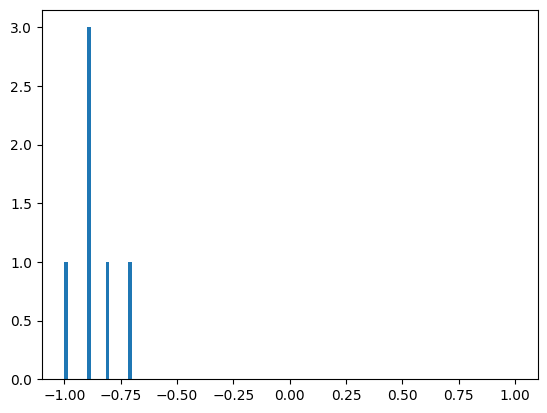

In [16]:
vm_threshold = 0.4
idx_plot = np.around(test_vm['vm_index'].values,1)
plt.hist(idx_plot[idx_plot<=-vm_threshold],bins=18)
plt.hist(idx_plot[idx_plot>=vm_threshold],bins=18)
a=plt.hist(idx_plot[np.logical_and(idx_plot>-vm_threshold,idx_plot<vm_threshold)],bins=18)

### Plot fr and circular max fr/localion

/home/INT/losada.c/Documents/codes/EphysVibe/ephysvibe/trials/spikes/plot_raster.py:517: RuntimeWarning: Mean of empty slice
  mean_sp = np.nanmean(shift_sp, axis=0)  # mean of all trials


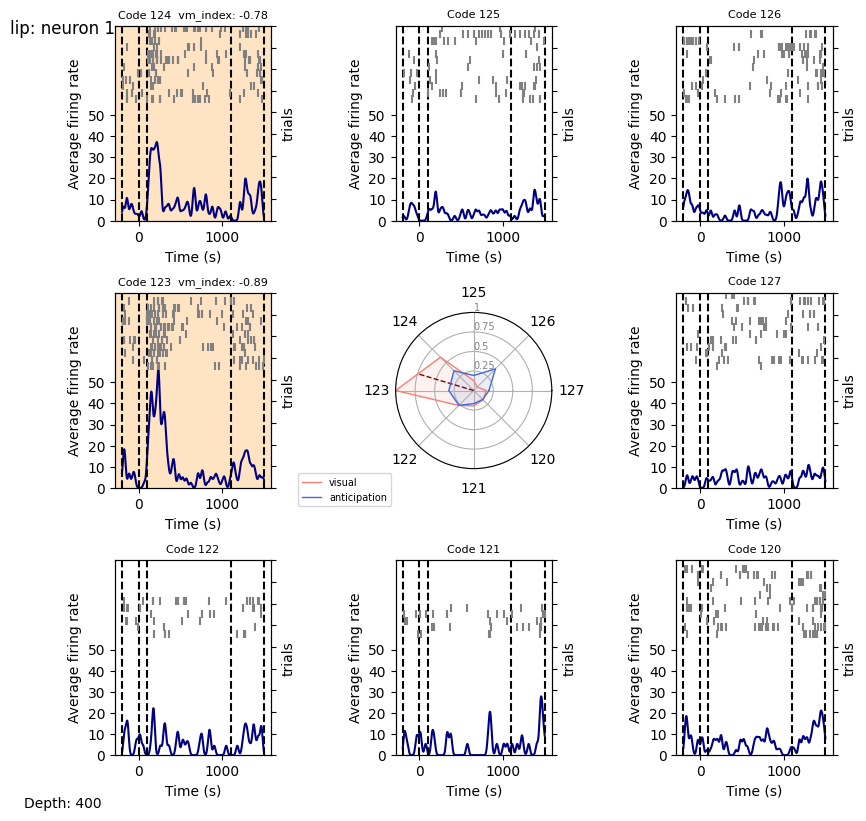

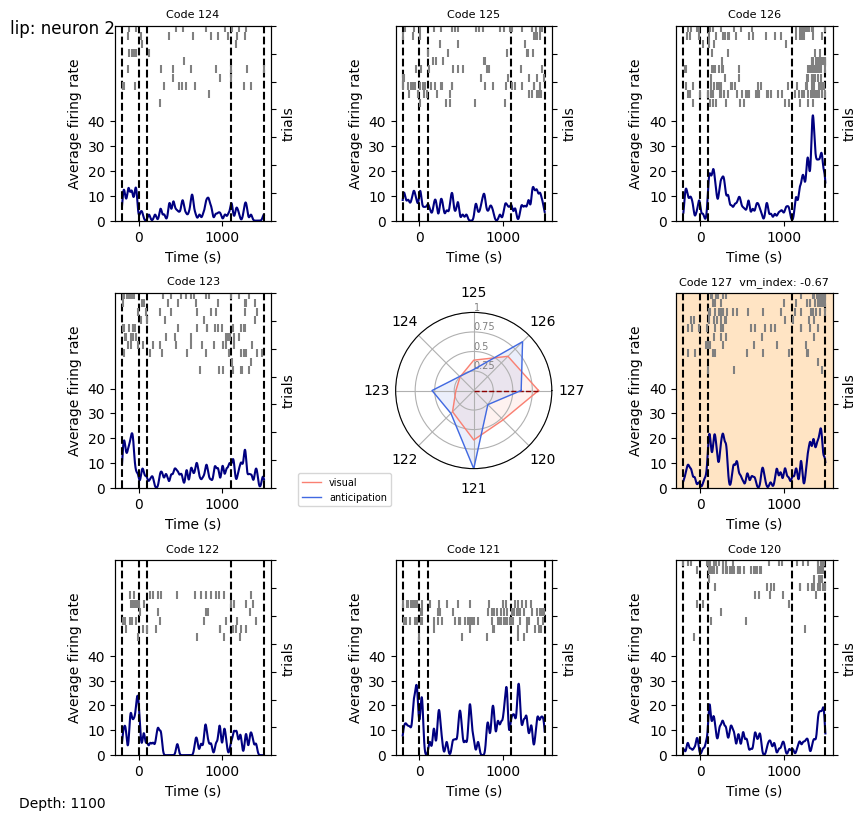

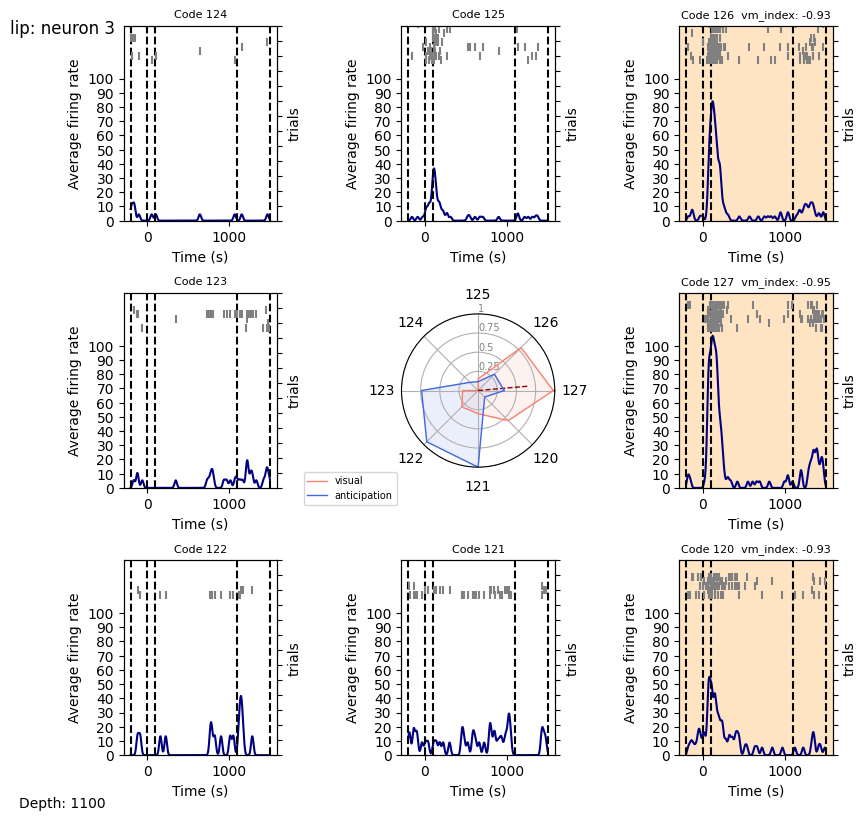

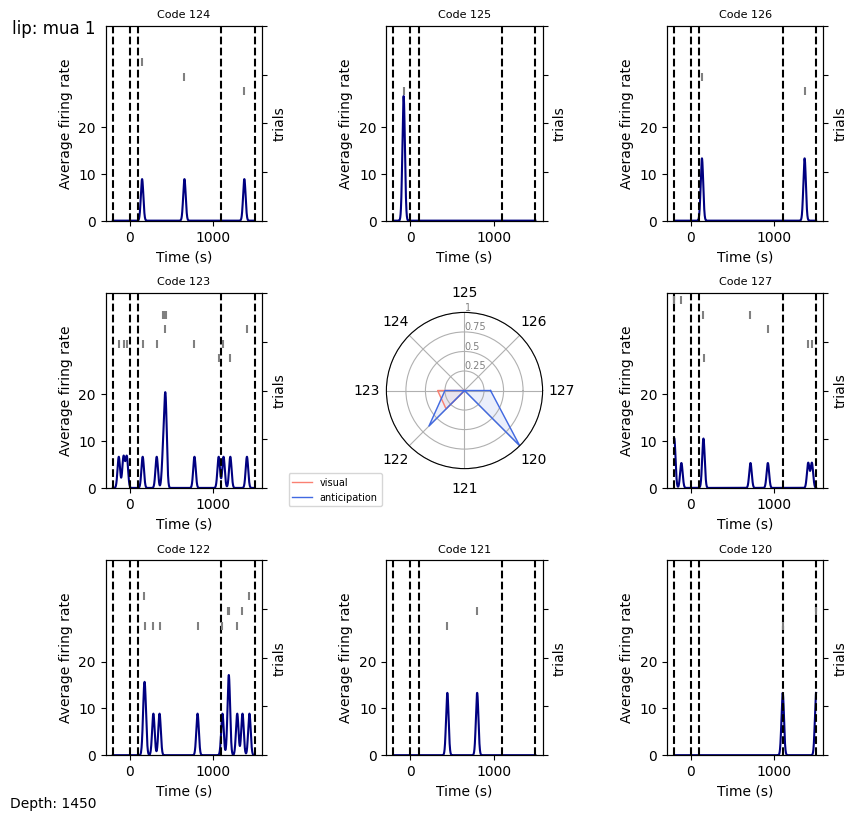

In [17]:
color = {
    "visual": ["salmon", "darkred", "--"],
    "anticipation": ["royalblue", "navy", ":"],
}
# kernel parameters
t_before = 200
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
win_size = int(sp_constants.W_SIZE * fs_ds)
code_samples = data.code_samples
code_numbers = data.code_numbers
sp_samples = data.sp_samples
e_code_align = task_constants.EVENTS_B2["target_on"]
# select only individual neurons
rf_coordinates: Dict[str, list] = defaultdict(list)
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup):  # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1
    fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True)  # define figure
    (
        all_ax,
        all_ax2,
        all_max_conv,
        max_num_trials,
    ) = plot_raster.plot_activity_location(
        target_codes,
        code_samples,
        code_numbers,
        sp_samples,
        i_n,
        e_code_align,
        t_before,
        fs_ds,
        kernel,
        test_vm,
    )
    # ------------------ plot spider in the center
    (
        fr_max_visual,
        fr_max_motor,
        fr_angle,
        fr_max_codes,
        v_significant,
        m_significant,
    ) = plot_raster.get_max_fr(
        target_codes,
        sp_samples,
        code_samples,
        code_numbers,
        i_n,
        kernel,
        win_size,
        fix_t,
        dur_v,
        e_code_align,
        test_vm,
        fs_ds,
    )
    codes_sig = np.logical_or(m_significant, v_significant)
    fr_code_max = max(fr_max_codes)
    vm_index, vm_index_v_fr, vm_index_p_fr = np.nan, np.nan, np.nan
    code_vm_index, code_index_v_fr, code_index_p_fr = np.nan, np.nan, np.nan
    vm_index_v_max, vm_index_p_max, code_v_max, code_p_max = (
        np.nan,
        np.nan,
        np.nan,
        np.nan,
    )

    if np.any(~np.isnan(fr_max_codes[codes_sig])):
        neu_test_vm = test_vm[test_vm["array_position"] == i_n]

        # select vm index of the code with the max fr
        idx_max_all = np.nanargmax(fr_max_codes[codes_sig])
        ang_max_all = fr_angle[codes_sig][idx_max_all]
        idx_code = np.where(pd.DataFrame(target_codes).iloc[3] == ang_max_all)[0][0]
        code = list(target_codes.keys())[idx_code]
        if code in neu_test_vm["code"].values:
            vm_index = neu_test_vm[neu_test_vm["code"] == code]["vm_index"].values[
                0
            ]
            code_vm_index = code
        if np.any(~np.isnan(fr_max_visual[v_significant])):
            # select vm index max visual fr
            idx_max_all = np.nanargmax(fr_max_visual[v_significant])
            ang_max_all = fr_angle[v_significant][idx_max_all]
            idx_code = np.where(pd.DataFrame(target_codes).iloc[3] == ang_max_all)[
                0
            ][0]
            code = list(target_codes.keys())[idx_code]
            if code in neu_test_vm["code"].values:
                vm_index_v_fr = neu_test_vm[neu_test_vm["code"] == code][
                    "vm_index"
                ].values[0]
                code_index_v_fr = code
            # select max visual vm index
            ang_max_all = fr_angle[v_significant]
            idx_code = np.where(
                np.isin(pd.DataFrame(target_codes).iloc[3].values, ang_max_all)
            )[0]
            code = np.array(list(target_codes.keys()))[idx_code]
            vm_index_v_max = neu_test_vm[np.isin(neu_test_vm["code"].values, code)]
            idx_max = np.argmax(np.abs(vm_index_v_max["vm_index"]))
            code_v_max = vm_index_v_max["code"].iloc[idx_max]
            vm_index_v_max = vm_index_v_max["vm_index"].iloc[idx_max]
        if np.any(~np.isnan(fr_max_motor[m_significant])):
            # select vm index max anticipation fr
            idx_max_all = np.nanargmax(fr_max_motor[m_significant])
            ang_max_all = fr_angle[m_significant][idx_max_all]
            idx_code = np.where(pd.DataFrame(target_codes).iloc[3] == ang_max_all)[
                0
            ][0]
            code = list(target_codes.keys())[idx_code]
            if code in neu_test_vm["code"].values:
                vm_index_p_fr = neu_test_vm[neu_test_vm["code"] == code][
                    "vm_index"
                ].values[0]
                code_index_p_fr = code
            # select max visual vm index
            ang_max_all = fr_angle[m_significant]
            idx_code = np.where(
                np.isin(pd.DataFrame(target_codes).iloc[3].values, ang_max_all)
            )[0]
            code = np.array(list(target_codes.keys()))[idx_code]
            vm_index_p_max = neu_test_vm[np.isin(neu_test_vm["code"].values, code)]
            idx_max = np.argmax(np.abs(vm_index_p_max["vm_index"]))
            code_p_max = vm_index_p_max["code"].iloc[idx_max]
            vm_index_p_max = vm_index_p_max["vm_index"].iloc[idx_max]

    ax = plt.subplot2grid((3, 3), (1, 1), polar=True)
    fr_angle_rad = (np.array(fr_angle) * 2 * np.pi) / 360
    fr_angle_rad = np.concatenate([fr_angle_rad, fr_angle_rad[:1]])

    for fr_max, event, significant in zip(
        [fr_max_visual, fr_max_motor],
        ["visual", "anticipation"],
        [v_significant, m_significant],
    ):
        norm_fr_max = np.array(fr_max) / fr_code_max
        # compute mean vector only visual or motor
        if np.any(significant):
            rad, ang = circular_stats.mean_vector(
                radius=norm_fr_max[significant],
                angle=fr_angle_rad[:-1][significant],
            )
            idx_max = np.nanargmax(fr_max)
            fr_max_n = fr_max[idx_max]
            ang_max_n = fr_angle[idx_max]

        else:
            rad, ang = np.nan, np.nan
            fr_max_n = np.nan
            ang_max_n = np.nan

        # compute mean vector of all significant positions/codes
        if np.any(codes_sig):
            rad_all, ang_all = circular_stats.mean_vector(
                radius=fr_max_codes[codes_sig] / fr_code_max,
                angle=fr_angle_rad[:-1][codes_sig],
            )
        else:
            rad_all, ang_all = np.nan, np.nan
        # plot max fr
        norm_fr_max = np.concatenate([norm_fr_max, norm_fr_max[:1]])
        ax.set_rlabel_position(90)
        plt.yticks(
            [0.25, 0.5, 0.75, 1], ["0.25", "0.5", "0.75", "1"], color="grey", size=7
        )
        plt.ylim(0, 1)
        plt.xticks(fr_angle_rad[:-1], target_codes.keys())
        ax.plot(
            fr_angle_rad,
            norm_fr_max,
            linewidth=1,
            linestyle="solid",
            color=color[event][0],
            label=event,
        )
        ax.fill(fr_angle_rad, norm_fr_max, alpha=0.1, color=color[event][0])
        # plot mean vector
        ax.plot(
            [0, ang],
            [0, rad],
            linewidth=1,
            linestyle=color[event][2],
            color=color[event][1],
        )
        plt.legend(loc="upper right", bbox_to_anchor=(0, 0), prop={"size": 7})
        # add results to df
        rf_coordinates["array_position"] += [i_n]
        rf_coordinates["neuron_type"] += [cluster]
        rf_coordinates["i_neuron"] += [i_cluster]
        rf_coordinates["event"] += [event]
        rf_coordinates["rad"] += [rad]
        rf_coordinates["ang"] += [ang]
        rf_coordinates["fr_max"] += [fr_max_n]
        rf_coordinates["ang_max"] += [ang_max_n]
        rf_coordinates["rad_all"] += [rad_all]
        rf_coordinates["ang_all"] += [ang_all]
        rf_coordinates["depth"] += [data.clusterdepth[i_n]]
        rf_coordinates["date"] += [s_path[-1][:19]]
        rf_coordinates["vm_index_frmax"] += [vm_index]
        rf_coordinates["code_vm_index"] += [code_vm_index]
        rf_coordinates["vm_index_v_fr"] += [vm_index_v_fr]
        rf_coordinates["code_index_v_fr"] += [code_index_v_fr]
        rf_coordinates["vm_index_p_fr"] += [vm_index_p_fr]
        rf_coordinates["code_index_p_fr"] += [code_index_p_fr]
        rf_coordinates["vm_index_v_max"] += [vm_index_v_max]
        rf_coordinates["code_v_max"] += [code_v_max]
        rf_coordinates["vm_index_p_max"] += [vm_index_p_max]
        rf_coordinates["code_p_max"] += [code_p_max]
    ## ------------------ end spider
    avg_events = [-200, 0, 100, 1100, 1500]
    # num_trials = sp_samples.shape[0]
    for ax, ax2 in zip(all_ax, all_ax2):
        for ev in avg_events:
            ax.vlines(
                ev,
                0,
                all_max_conv + max_num_trials * 3,
                color="k",
                linestyles="dashed",
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials * 3)
        ax.set_yticks(np.arange(0, all_max_conv, 10))
        ax2.set_ylim(-all_max_conv, max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv, max_num_trials * 3, 10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)
    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    fig.suptitle("%s: %s %d" % (s_path[-3], cluster, i_cluster), x=0)
    fig.text(
        0,
        0,
        s="Depth: %d" % data.clusterdepth[i_n],
        horizontalalignment="center",
        verticalalignment="center",
    )
rf_coordinates = pd.DataFrame(rf_coordinates)

In [18]:

rf_coordinates[~rf_coordinates["rad"].isnull()][['array_position','neuron_type','i_neuron','vm_index_frmax']]

,array_position,neuron_type,i_neuron,vm_index_frmax
0,0,neuron,1,-0.888525
2,1,neuron,2,-0.670683
4,2,neuron,3,-0.954751


In [19]:
rf = rf_coordinates[['array_position','rad', 'event', 'depth', 'vm_index_frmax', 'code_vm_index',
       'vm_index_v_fr', 'code_index_v_fr', 'vm_index_p_fr', 'code_index_p_fr',
       'vm_index_v_max', 'code_v_max', 'vm_index_p_max', 'code_p_max']]
rf = rf[~rf["rad"].isnull()]
rf

,array_position,rad,event,depth,vm_index_frmax,code_vm_index,vm_index_v_fr,code_index_v_fr,vm_index_p_fr,code_index_p_fr,vm_index_v_max,code_v_max,vm_index_p_max,code_p_max
0,0,0.744558,visual,400.0,-0.888525,123,-0.888525,123,NaN,NaN,-0.888525,123,NaN,NaN
2,1,0.829323,visual,1100.0,-0.670683,127,-0.670683,127,NaN,NaN,-0.670683,127,NaN,NaN
4,2,0.647080,visual,1100.0,-0.954751,127,-0.954751,127,NaN,NaN,-0.954751,127,NaN,NaN


In [20]:
rf_coordinates[['array_position', 'event', 'rad', 'ang', 'fr_max', 'ang_max', 'rad_all',
       'ang_all', 'depth', 'date', 'vm_index_frmax', 'code_vm_index']]

,array_position,event,rad,ang,fr_max,ang_max,rad_all,ang_all,depth,date,vm_index_frmax,code_vm_index
0,0,visual,0.744558,2.850988,55.798536,180.0,0.744558,2.850988,400.0,2023-02-09_10-42-54,-0.888525,123
1,0,anticipation,NaN,NaN,NaN,NaN,0.744558,2.850988,400.0,2023-02-09_10-42-54,-0.888525,123
2,1,visual,0.829323,0.000000,23.836865,0.0,0.829323,0.000000,1100.0,2023-02-09_10-42-54,-0.670683,127
3,1,anticipation,NaN,NaN,NaN,NaN,0.829323,0.000000,1100.0,2023-02-09_10-42-54,-0.670683,127
4,2,visual,0.647080,0.086459,43.153665,0.0,0.647080,0.086459,1100.0,2023-02-09_10-42-54,-0.954751,127
5,2,anticipation,NaN,NaN,NaN,NaN,0.647080,0.086459,1100.0,2023-02-09_10-42-54,-0.954751,127
6,3,visual,NaN,NaN,NaN,NaN,NaN,NaN,1450.0,2023-02-09_10-42-54,NaN,NaN
7,3,anticipation,NaN,NaN,NaN,NaN,NaN,NaN,1450.0,2023-02-09_10-42-54,NaN,NaN
